In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib
import os

In [3]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')

No GPU detected
No GPUs available


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = '/content/drive/MyDrive/pattern project/Eye_diseases/dataset'
os.listdir(data_dir)

['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

In [6]:
tf.random.set_seed(42)

train_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'training', seed = 1, shuffle = True, batch_size = 16, image_size=(256,256))

test_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'validation', seed = 1, shuffle = True, batch_size = 16, image_size=(256,256))

Found 4237 files belonging to 4 classes.
Using 3814 files for training.
Found 4237 files belonging to 4 classes.
Using 423 files for validation.


In [7]:
filenames = pathlib.Path(data_dir)
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

cataract : 1038
diabetic_retinopathy : 1108
glaucoma : 1017
normal : 1074


In [8]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy()

(239, 27)

In [9]:
#Split Training Data Further:
train_set = train_data.take(212)
val_set = train_data.skip(212)
train_set.cardinality().numpy(), val_set.cardinality().numpy()

(212, 27)

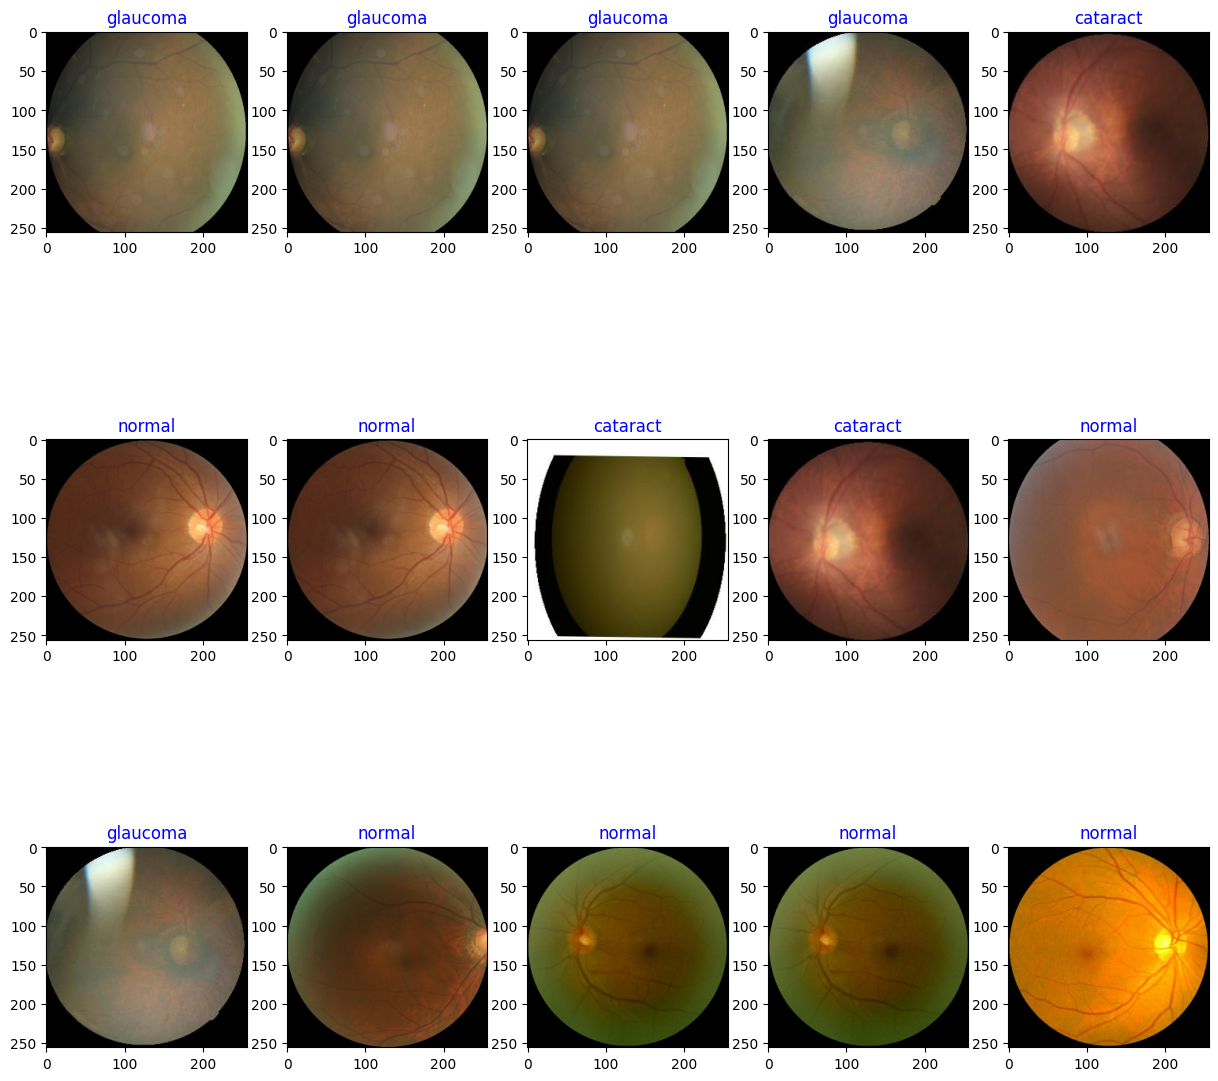

In [10]:
# Print random images from the train set
plt.figure(figsize=(15, 15))
for images, labels in train_set.take(1):
    for i in range(15):
        index = random.randint(0, len(images) - 1)  # Fix the index range
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[index]], color='blue', fontsize=12)
        plt.axis(True)
plt.show()


In [11]:
#Print Shape of Batch:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


In [12]:
#Loading Pre-trained VGG16 Model
from tensorflow.keras.applications import VGG16

In [13]:
vgg16Model = VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
vgg16Model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [15]:
vgg16Model.trainable = True

In [16]:
from tensorflow.keras import layers

In [17]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    vgg16Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [18]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
history_2 = model2.fit(train_set, epochs=20, validation_data=val_set)


Epoch 1/20
 77/212 [=========>....................] - ETA: 1:43:42 - loss: 1.1515 - accuracy: 0.5162